In [1]:
import requests
from bs4 import BeautifulSoup
import csv
import ftfy
from fpdf import FPDF
import re
from datetime import datetime

# Please add your API key here
API_KEY = ""

# ------------------------- #
# 1️⃣ Web scrapping Phase   #
# ------------------------- #

def fetch_movie_titles():
    print("Fetch movie titles from Rotten tomatoes and Box Office Mojo...\n")

    """I'm getting an error while loading all movies into output evening, clear the movie titles from here itself"""
    
    try:
        # Website1: Rotten Tomatoes
        rotten_tomatoes_url = "https://www.rottentomatoes.com/browse/movies_in_theaters"

        # Mimic the browser
        headers = {"User-Agent": "Mozilla/5.0"}
        
        response_rotten_tomatoes = requests.get(rotten_tomatoes_url, headers = headers)

        # Check the url is working or not
        if response_rotten_tomatoes.status_code != 200:
            print(f"❌failed to fetch the data from Rotten Tomatoes. Status Code: {response_rotten_tomatoes.status_code}")
        
        # Parsing the HTML content from Box Office Mojo
        soup1 = BeautifulSoup(response_rotten_tomatoes.content, "html.parser")

        # Extract movie titles from Rotten Tomatoes website
        rotten_tomatoes_titles = [tag.get("href").split("/")[-1].replace("-", " ").title() 
                       for tag in soup1.select("a.js-tile-link")]

        # This line can replace underscore in the movie titles as space
        cleaned_rotten_tomatoes_titles = [title.replace("_", " ").strip() for title in rotten_tomatoes_titles]
        
        print(f"Total ({len(cleaned_rotten_tomatoes_titles)}) movie titles found in Rotten Tomatos\n")
        print(f"✅ Fetched Movie Titles from 🍅 Rotten Tomatoes website...\n")
        print(cleaned_rotten_tomatoes_titles[:10], "\n") #It is not loading more than 10 movies

        # Website2: Box Office Mojo
        box_office_mojo_url = "https://www.boxofficemojo.com/weekend/"
        response_box_office_mojo = requests.get(box_office_mojo_url, headers = headers)

        # Check the url is working or not
        if response_box_office_mojo.status_code != 200:
            print(f"❌failed to fetch the data from Box Office Mojo. Status Code: {response_box_office_mojo.status_code}")
        
        # Parsing the HTML content from Box Office Mojo
        soup2 = BeautifulSoup(response_box_office_mojo.text, "html.parser")

        # Extract movie titles from Box office mojo
        box_office_mojo_titles = [tag.get_text(strip=True)
                              for tag in soup2.select("td.a-text-left.mojo-field-type-release a.a-link-normal")]
        print(f"Total ({len(box_office_mojo_titles)}) movie titles found in Box Office Mojo Website\n")
        #print(soup.prettify())
        print(set(box_office_mojo_titles[:20]),"\n")

        #return box_office_mojo_titles

        print("✅ Combining the movie titles from Box Office Mojo and Rotten Tomatoes websites....\n")
        total_movie_titles = list(set(cleaned_rotten_tomatoes_titles + box_office_mojo_titles))
        print(f"{total_movie_titles}\n")
        
        #print(f"Total ✅ Fetched movies from Rotten Tomatoes and Box Office Mojo is {total_movie_titles}\n")

        return total_movie_titles

    except requests.exceptions.RequestException as e:
        print(f"❌ Error while scapping Rotten Tomatoes: {e}")
        return[]

# Test the function
# titles = fetch_movie_titles()
#print(titles)

# --------------------- #
# 2️⃣ Extract Phase     #
# --------------------- #

def extract_movies(titles):
    print("🚀 Fetching Data from OMDB API....🎬")
    movies = []

    for title in titles: 
        url = f"http://www.omdbapi.com/?t={title}&apikey={API_KEY}"
        try:
            response = requests.get(url, timeout=10)
            data = response.json()

            if data.get("Response") == "True":
                movies.append(data)
            else:
                print(f"❌ Movie not found: {title}")

        except requests.exceptions.RequestException as e:
            print(f"❌ Request Error for {title}: {e}")

    print(f"✅ Fetched {len(movies)} movies successfully!\n")
    return movies

# --------------------- #
# 3️⃣ Transform Phase   #
# --------------------- #

def transform_data(movies):
    print("🔄 Transforming Data...🧹")
    transformed_movies = []

    for movie in movies:
        # Task1 - Movie Title Transformation
            # Remove Special Characters: Use regular expressions to eliminate non-alphanumeric characters. 
            # Standardized Case: Convert all titles to Title Case for consistency. 
        # Trim Whitespaces: Remove leading/trailing spaces to maintain uniformity.

        title_clean = re.sub(r'[^\w\s]', '',movie.get('Title', "").strip()).title()

        # Task2 - Release Date Transformation
            # Date Formatting: Replace spaces with hyphens to standardize the date format (e.g., DD MMM YYYY to DD-MMM-YYYY).
            # Convert to Date Object: Use date parsing to convert text dates into proper date formats.
            # Handle Missing Dates: Replace missing dates with "Unknown." 

        release_date = movie.get("Released", "N/A")
        cleaned_release_date = (datetime.strptime(release_date, "%d %b %Y").strftime("%Y-%m-%d")
                                    if release_date != "N/A" else "Unknown")

        # Task3 - Genre Transformation
            # Convert to Lowercase: Ensure all genres are in lowercase for consistency.
            # Split Genres: If multiple genres are present, separate them into a list.
            # Remove Duplicates: Ensure unique genre entries.

        genres = list(set([genre.strip().lower() for genre in movie.get("Genre", "").split(",")]))

        # Task4 -  IMDb Rating Transformation
            # Convert to Numeric: Change rating from text to a floating-point number.
            # Round Off: Round ratings to one decimal place. 
            # Normalize: Optionally, normalize ratings on a scale of 0 to 1.

        imdb_rating = round(float(movie.get("imdbRating",0)), 1) if movie.get("imdbRating") != "N/A" else 0
        imdb_rating_normalized = imdb_rating / 10 if imdb_rating else 0

        # Task5 -  Actors Transformation
            # Limit to Top 3: Display only the top three actors.
            # Trim Spaces: Remove extra spaces around names. 
            # Sort Alphabetically (Optional): For consistency in display.

        actors = ", ".join(sorted([actor.strip() for actor in movie.get("Actors", "").split(",")[:3]]))
        
        # Task6 - Box Office Transformation 
            # Remove Currency Symbols: Eliminate $, ,, and other non-numeric characters.
            # Convert to Numeric: Store as an integer for analysis. 
            # Handle Missing Data: Replace missing values with 0 or N/A.

        box_office = re.sub(r'[^\d]', '', movie.get("BoxOffice", ""))
        cleaned_box_office = int(box_office) if box_office else "N/A"

        # Task7 - Awards Transformation
            # Extract Numbers: Identify and sum all numeric values related to awards won.
            # Standardize Format: Display total awards won. 
            # Handle Missing Awards: Set to 0 if no data is available.

        awards_text = movie.get("Awards", "")
        cleaned_awards = re.sub(r'[^\d]', '', awards_text)
        numbers_in_awards = [int(num) for num in cleaned_awards.split()] if cleaned_awards else []
        total_awards = sum(numbers_in_awards) if numbers_in_awards else 0

        # Task8 - Metascore Transformation
            # Convert to Integer: Change metascore to an integer for calculations.
            # Normalize: Convert to a 0-1 scale by dividing by 100.
            # Handle Missing Values: Replace "N/A" with None. 

        metascore = re.sub(r'[^\d]', '', movie.get("Metascore", ""))
        cleaned_metascore = round(100/(int(metascore))) if metascore.isdigit() else "N/A"

        # Task9 - Language Transformation
            # Convert to Lowercase: Ensure all language names are in lowercase.
            # Standardize Codes: Optionally convert to ISO language codes.
            # Handle Missing Data: Replace missing languages with "Unknown."

        language = re.sub(r'[^\w\s]', "", movie.get("Language", ""))
        cleaned_language = ",".join(language.strip().lower().split()) if language else "Unknown."
        # cleaned_language = (lang.strip().lower() for lang in language.split(",")) if language else "unknown"


        # Task10 - Production Transformation
            # Remove Special Characters: Clean the production company names.
            # Standardize Names: Correct common misspellings and standardize abbreviations. 
            # Handle Missing Data: Replace missing production companies with "Independent."

        production = movie.get("Production", "")
        cleaned_production = re.sub(r'[^\w\s]', '', production if production else "Independent.")

        # Appending the movies data to the movies
        transformed_movies.append({
            "Title": title_clean,
            "Released Date": cleaned_release_date,
            "Genre": genres,
            "IMDB Rating": imdb_rating,
            "Normalized IMDB Rating": imdb_rating_normalized,
            "Top 3 Actors": actors,
            "Box Office": cleaned_box_office,
            "Total Awards": total_awards,
            "Metascore": cleaned_metascore,
            "Language": cleaned_language,
            "Production": cleaned_production
        })

    print(f"✨ Transformation is complete for {len(transformed_movies)} movies!\n")
    return transformed_movies

# --------------------- #
# 4️⃣ Load Phase   #
# --------------------- #

def load_to_csv(data):
    print("💾 Saving data to CSV...📊")
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"movies1_{timestamp}.csv" #Add Time Stamp to Overwrite

    with open(filename, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=data[0].keys())
        writer.writeheader()
        writer.writerows(data)

    print(f"✅ Data successfully saved to {filename}!\n")

# --------------------- #
# 🚀 Execute ETL Pipeline   #
# --------------------- #
if __name__ == "__main__":
    titles = fetch_movie_titles()
    if titles:
        movies = extract_movies(titles)
        if movies:
            transformed_data = transform_data(movies)
            load_to_csv(transformed_data)

        else:
            print("⚠️ No Movie data fetched from the API.")
    
    else:
        print("⚠️ No Movie titles found during scapping. ")

# -------------------------------------- #
# 📝 Convert the CSV file to PDF file   #
# ------------------------------------- #

def load_to_pdf(data):
    print("📝 Generating PDF Report... 📄")
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f"movies_{timestamp}.pdf"

    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)

    # ✅ Title
    pdf.cell(200, 10, "Movie Insights Report", ln=True, align="C")
    pdf.ln(5)

    # 🔹 Add Data with Bifurcation Lines
    for movie in data:
        pdf.set_font("Arial", style='B', size=12)  # Bold for Title
        pdf.cell(0, 8, f" {movie.get('Title', 'N/A')}", ln=True)
        pdf.set_font("Arial", size=11)

        for key, value in movie.items():
            if key != "Title":  # Skip repeating the title
                pdf.multi_cell(0, 8, f"{key}: {value}")

        # 🚀 Add a Bifurcation Line for Separation
        pdf.set_draw_color(0, 0, 0)  # Black color
        pdf.set_line_width(0.5)
        pdf.line(10, pdf.get_y(), 200, pdf.get_y())  # Draw horizontal line
        pdf.ln(5)  # Add space after the line

    pdf.output(filename)
    print(f"✅ PDF report saved as {filename}!\n")
load_to_pdf(transformed_data)

Fetch movie titles from Rotten tomatoes and Box Office Mojo...

Total (11) movie titles found in Rotten Tomatos

✅ Fetched Movie Titles from 🍅 Rotten Tomatoes website...

['Purple Rain', 'My Motherland', 'Open Your Eyes Jeffrey', 'Guns Of Redemption', 'The Visitor 2024', 'The Way My Way', 'Play It As It Lays', 'The Corpse', 'A Match', 'You Burn Me'] 

Total (11) movie titles found in Box Office Mojo Website

{'Flight Risk', 'Mufasa: The Lion King', 'Dog Man', 'Den of Thieves: Pantera', 'Captain America: Brave New World'} 

✅ Combining the movie titles from Box Office Mojo and Rotten Tomatoes websites....

['Open Your Eyes Jeffrey', 'Flight Risk', 'Mufasa: The Lion King', 'The Corpse', 'Guns Of Redemption', 'Play It As It Lays', 'Dog Man', 'The Way My Way', 'Purple Rain', 'Captain America: Brave New World', 'My Motherland', 'The Visitor 2024', 'Ufc 313 Pereira Vs Ankalaev', 'Den of Thieves: Pantera', 'You Burn Me', 'A Match']

🚀 Fetching Data from OMDB API....🎬
❌ Movie not found: Open Y

# Optional Enhancements: Data Visualization

In [37]:
pip install pandas matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [19]:
# load the CSV file
import pandas as pd

# Load the CSV file
df = pd.read_csv(r"C:\Users\myoge\Downloads\movies1_20250308_223601.csv")

df.head()

,Title,Released Date,Genre,IMDB Rating,Normalized IMDB Rating,Top 3 Actors,Box Office,Total Awards,Metascore,Language,Production
0,Guns Of Redemption,2025-03-07,['western'],0.0,0.00,"Casper Van Dien, Kaitlyn Kemp, Siena Bjornerud",NaN,0,NaN,english,NaN
1,A Match,2023-09-08,['drama'],0.0,0.00,"Nandini Chikte, Sangita Sonekar, Taranath Khir...",NaN,137,NaN,marathi,NaN
2,The Way My Way,2024-05-16,['drama'],6.7,0.67,"Chris Haywood, Jennifer Cluff, Laura Lakshmi",NaN,0,NaN,english,NaN
3,Dog Man,2025-01-31,"['animation', 'action', 'adventure']",6.5,0.65,"Lil Rel Howery, Pete Davidson, Poppy Liu",38673255.0,0,2.0,english,NaN
4,You Burn Me,2024-10-03,['drama'],0.0,0.00,"Agustina Muñoz, Ana Cristina Barragán, Maria I...",NaN,5,NaN,english,NaN


In [5]:
# Install Required Libraries
!pip install dash jupyter-dash plotly pandas

C:\Users\myoge\AppData\Local\Temp\ipykernel_15056\3641032174.py:18: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.

C:\Users\myoge\AppData\Local\Temp\ipykernel_15056\3641032174.py:41: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




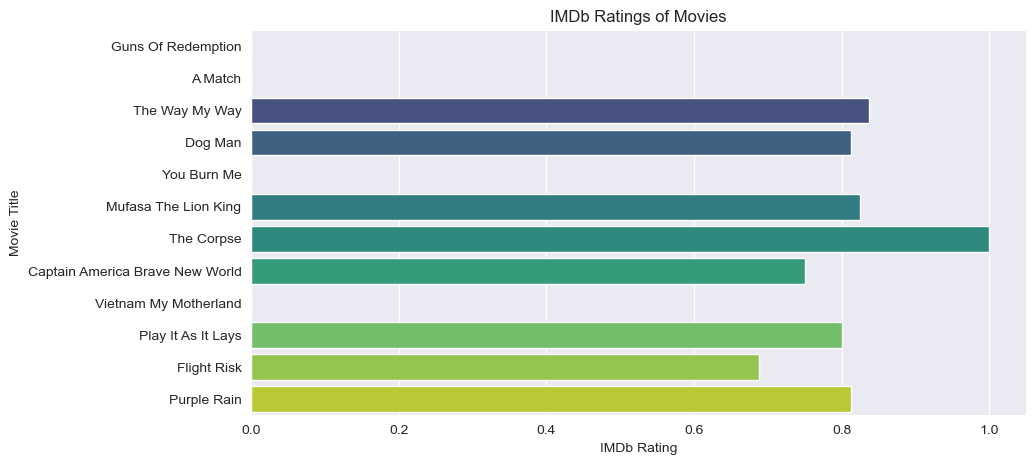

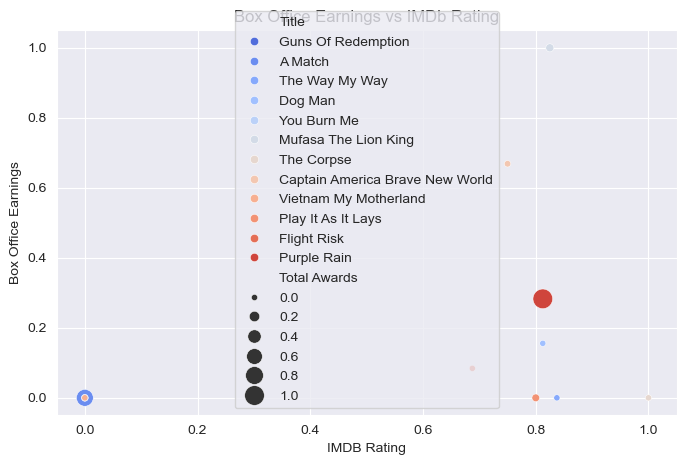

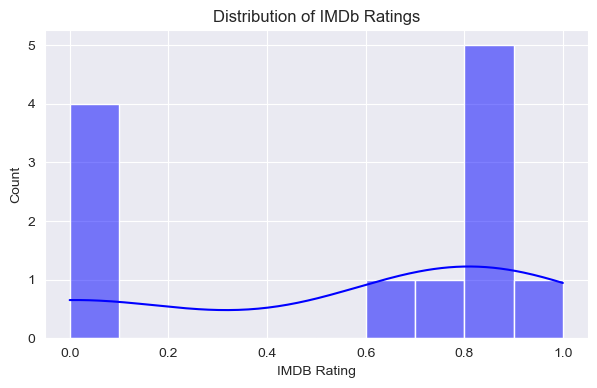

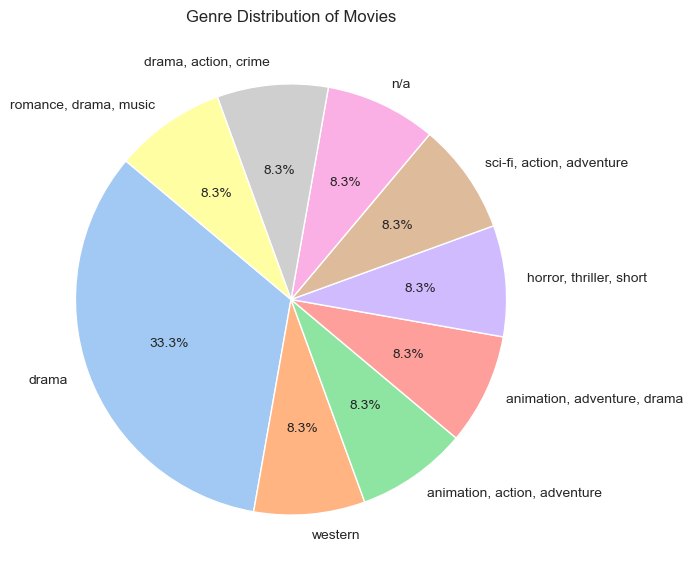

Data Processing and Visualization Complete! 🎉


In [39]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Load the CSV file
df = pd.read_csv(r"C:\Users\myoge\Downloads\movies1_20250308_223601.csv")

# ------------------------ #
# 1️⃣ Data Cleaning Phase  #
# ------------------------ #

# Convert Release Date to datetime format
df["Released Date"] = pd.to_datetime(df["Released Date"], errors="coerce")

# Fill missing values with 0
df.fillna(0, inplace=True)

# Convert categorical columns to string (if needed)
df["Genre"] = df["Genre"].astype(str)

# Remove unnecessary characters from Genre column
df["Genre"] = df["Genre"].str.replace("[", "").str.replace("]", "").str.replace("'", "")

# ------------------------ #
# 2️⃣ Feature Scaling (Optional) #
# ------------------------ #
scaler = MinMaxScaler()
df[["IMDB Rating", "Box Office", "Total Awards"]] = scaler.fit_transform(df[["IMDB Rating", "Box Office", "Total Awards"]])

# ------------------------ #
# 3️⃣ Data Visualization  #
# ------------------------ #

# Set style for plots
sns.set_style("darkgrid")

# 1️⃣ Bar Chart: IMDb Ratings of Movies
plt.figure(figsize=(10,5))
sns.barplot(data=df, x="IMDB Rating", y="Title", palette="viridis")
plt.xlabel("IMDb Rating")
plt.ylabel("Movie Title")
plt.title("IMDb Ratings of Movies")
plt.show()

# 2️⃣ Scatter Plot: IMDb Rating vs. Box Office
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="IMDB Rating", y="Box Office", hue="Title", size="Total Awards", sizes=(20, 200), palette="coolwarm")
plt.xlabel("IMDB Rating")
plt.ylabel("Box Office Earnings")
plt.title("Box Office Earnings vs IMDb Rating")
plt.show()

# 3️⃣ Histogram: Distribution of IMDb Ratings
plt.figure(figsize=(7,4))
sns.histplot(df["IMDB Rating"], bins=10, kde=True, color="blue")
plt.xlabel("IMDB Rating")
plt.title("Distribution of IMDb Ratings")
plt.show()

# 4️⃣ Pie Chart: Genre Distribution
genre_counts = df["Genre"].value_counts()

plt.figure(figsize=(7,7))
plt.pie(genre_counts, labels=genre_counts.index, autopct="%1.1f%%", startangle=140, colors=sns.color_palette("pastel"))
plt.title("Genre Distribution of Movies")
plt.show()

# ------------------------ #
# ✅ Final Output #
# ------------------------ #
print("Data Processing and Visualization Complete! 🎉")


# Another Way to do the Data Visulization.

In [9]:
# Create a Basic Dash app
from dash import Dash 
import plotly.express as px
import pandas as pd
from dash import dcc, html

# Load the CSV file
df = pd.read_csv(r"C:\Users\myoge\Downloads\movies1_20250308_233040.csv")

# Convert Release Date to datetime (if applicable)
df["Released Date"] = pd.to_datetime(df["Released Date"], errors="coerce")

# Initialize Dash app
app = Dash(__name__)

# Layout of the app
app.layout = html.Div(children=[
    html.H1("📊 Movie Data Visualization", style={'textAlign': 'center'}),

    # Dropdown for selecting different numeric attributes
    dcc.Dropdown(
        id="attribute-dropdown",
        options=[
            {"label": "IMDB Rating", "value": "IMDB Rating"},
            {"label": "Metascore", "value": "Metascore"},
            {"label": "Box Office", "value": "Box Office"},
            {"label": "Total Awards", "value": "Total Awards"}
        ],
        value="IMDB Rating",
        clearable=False,
        style={'width': '50%'}
    ),

    # Graph for dynamic selection
    dcc.Graph(id="bar-chart"),
])

# Callback function to update the graph
@app.callback(
    dash.Output("bar-chart", "figure"),
    [dash.Input("attribute-dropdown", "value")]
)
def update_graph(selected_attribute):
    fig = px.bar(df, x="Title", y=selected_attribute, title=f"Movies vs {selected_attribute}", color="Title")
    return fig

# Run the app inside Jupyter Notebook
app.run_server(jupyter_mode="inline", port=8053)
